In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.ndimage import gaussian_filter

In [2]:
# choose whether to load dataset with pickle or hdf5 files (using hickle)
use_pickle = False

if use_pickle:
    import pickle
    data_path = "dataset_pickle"
    file_ext = "pickle"
else:
    import hickle
    data_path = "MHD_data/dataset_h5"
    file_ext = "h5"

In [3]:
def load_shot(shotno):
    with open(os.path.join(data_path, f"{shotno}.{file_ext}"), "rb") as f:
        if use_pickle:
            return pickle.load(f)
        else:
            return hickle.load(f)
        
def walk(struct, prefix="", append="  "):
    # simple function to inspect dict without printing all contents
    for key, item in struct.items():
        if not isinstance(item, dict):
            postfix = "" if not isinstance(item, np.ndarray) else f"{item.shape}"
            print(f"{prefix}{key}: var <{type(item).__name__}> {postfix}")
        else:
            print(f"{prefix}{key}\n{prefix}" + "{")
            walk(item, prefix=prefix+append, append=append)
            print(f"{prefix}" + "}")

In [4]:
# get all shot nos
all_shots = [int(os.path.basename(x.split(f".{file_ext}")[0])) 
             for x in glob.glob(os.path.join(data_path, f"*.{file_ext}"))]
if len(all_shots) < 94:  # check if all data is there
    print(f"[using dataset mode {'pickle' if use_pickle else 'hdf5'}]")
    raise ValueError(f"Not all shots found in path /{data_path}/; found only {len(all_shots)} out of 94")

In [5]:
print(f"List of all shots/pulses:")
print(all_shots)

List of all shots/pulses:
[64374, 64376, 64378, 64389, 64392, 64394, 64401, 64646, 64647, 64648, 64649, 64650, 64658, 64659, 64662, 64664, 64666, 64668, 64670, 64673, 64675, 64677, 64678, 64680, 64682, 64684, 64686, 64770, 64774, 64778, 64820, 64834, 70355, 70356, 70357, 70359, 70380, 70381, 70382, 70383, 70387, 70388, 70389, 70390, 70391, 70392, 70393, 70394, 71182, 71186, 71188, 71189, 71190, 71192, 71193, 71194, 71222, 71223, 71224, 71225, 71226, 71255, 71256, 71259, 71260, 71264, 71265, 71266, 71292, 71300, 71303, 72196, 72198, 72919, 72920, 72925, 72926, 72927, 72928, 72929, 72930, 72959, 72961, 72963, 72964, 72965, 72966, 72967, 73018, 73019, 73020, 73021, 73022, 73023]


In [6]:
shotno = all_shots[38]
print(f"Example structure of shot #{shotno}:")
data_shot = load_shot(shotno)
walk(data_shot)

Example structure of shot #70382:
x
{
  spectrogram
  {
    OddN: var <ndarray> (3573, 2049)
    EvenN: var <ndarray> (3573, 2049)
    time: var <ndarray> (3573,)
    frequency: var <ndarray> (2049,)
  }
}
y
{
  modes
  {
    time: var <ndarray> (9156,)
    N0: var <ndarray> (9156,)
    N1: var <ndarray> (9156,)
    N2: var <ndarray> (9156,)
    N3: var <ndarray> (9156,)
    N4: var <ndarray> (9156,)
    LM: var <ndarray> (9156,)
  }
}


The main purpose of this project is to identify modes, which can be spotted as 'lines' or 'bands' in the frequency spectrum. More precisely, we want to find the start:end time given these 2D plots, see below:


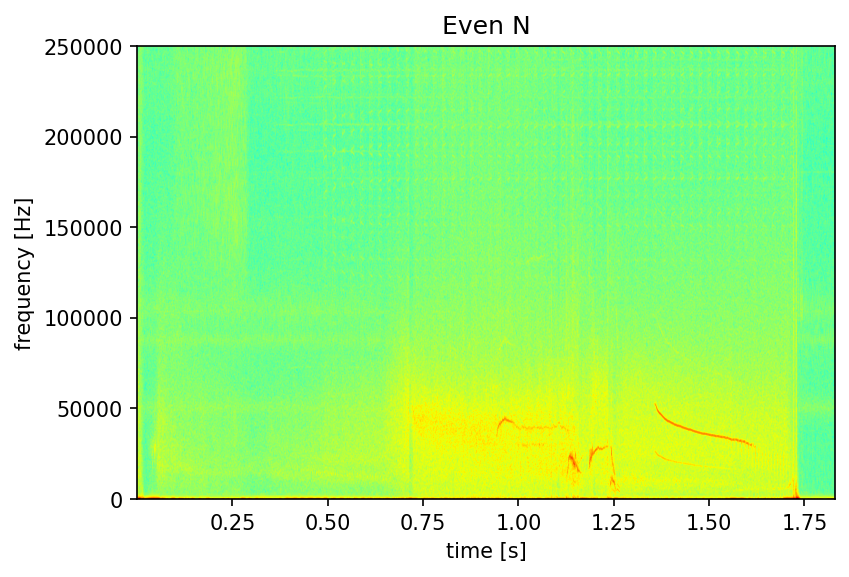

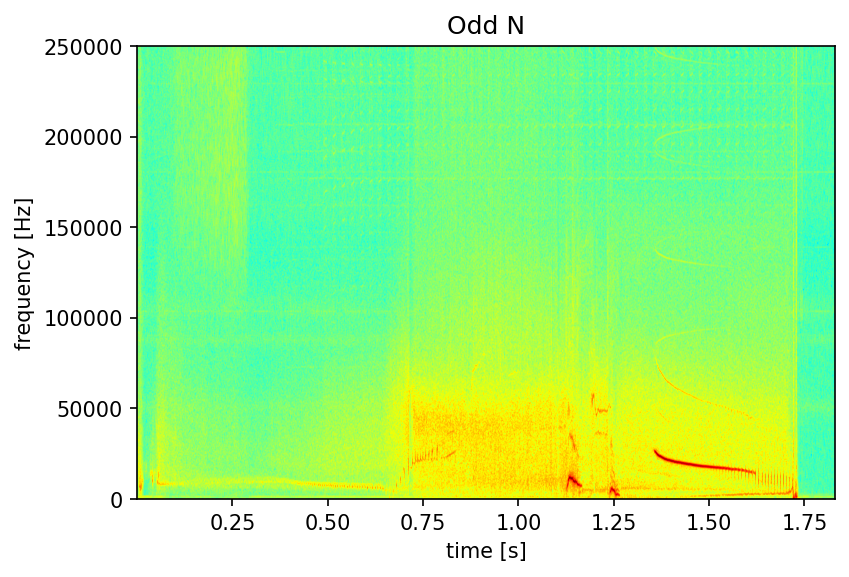

In [7]:
inputs = data_shot["x"]["spectrogram"]
spec_even = inputs["EvenN"]
spec_odd = inputs["OddN"]
f = inputs["frequency"]
t = inputs["time"]
fig, ax = plt.subplots()
ax.imshow(spec_even[::, ::-1].T, extent=(t[0], t[-1], f[0], f[-1]), aspect='auto', cmap='jet')
ax.set_xlim(t[0], t[-1])
ax.set_ylim(f[0], f[-1])
ax.set_xlabel("time [s]")
ax.set_ylabel("frequency [Hz]")
fig.set_dpi(150)
plt.title("Even N")
plt.show()
fig, ax = plt.subplots()
ax.imshow(spec_odd[::, ::-1].T, extent=(t[0], t[-1], f[0], f[-1]), aspect='auto', cmap='jet')
ax.set_xlim(t[0], t[-1])
ax.set_ylim(f[0], f[-1])
ax.set_xlabel("time [s]")
ax.set_ylabel("frequency [Hz]")
fig.set_dpi(150)
plt.title("Odd N")
plt.show()

Both the Even N / Odd N spectrograms can be used, in the following example we can clearly identify a mode around ~1.35s (Bestl illustrated in the Odd N spectrogram, zooming in on the lower frequences):

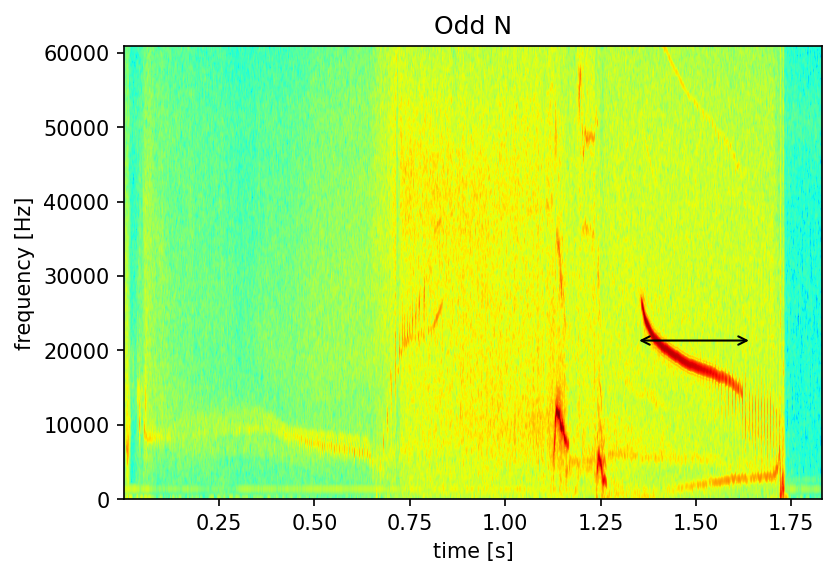

In [8]:
f_zoomed = f[:500] # zoom in on first frequency range
spec_odd_zoomed = spec_odd[:, :500]
fig, ax = plt.subplots()
ax.imshow(spec_odd_zoomed[::, ::-1].T, extent=(t[0], t[-1], f_zoomed[0], f_zoomed[-1]), aspect='auto', cmap='jet')

# annotate 2 modes
mode_timing = (1.34, 1.65)
ax.annotate('', xy=(mode_timing[0] / t[-1], 0.35), xycoords='axes fraction', xytext=(mode_timing[1] / t[-1], 0.35), 
                    arrowprops=dict(arrowstyle="<->", color='black'))

ax.set_xlim(t[0], t[-1])
ax.set_ylim(f_zoomed[0], f_zoomed[-1])
ax.set_xlabel("time [s]")
ax.set_ylabel("frequency [Hz]")
fig.set_dpi(150)
plt.title("Odd N")
plt.show()

Traditional computer vision techniques could be used to extract start/end times of this shape directly from the spectrogram (looking for e.g. lines). 
Alternatively, one could use other measurements to create 'pseudo labels' to build a data driven model.

We store these extra measurements in 'y'. Note that 'y' is not assumed to be directly available: you can use it to build a dataset as in traditional machine learning, but it is not available at test time. An example of these mode amplitudes is plotted below:

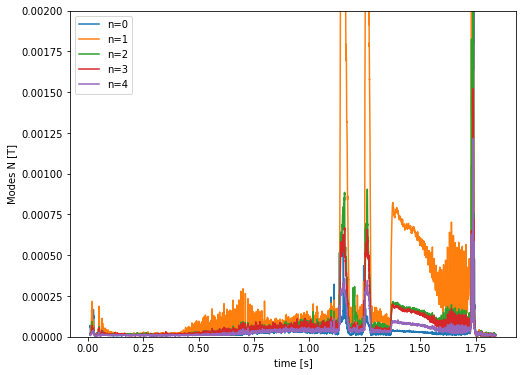

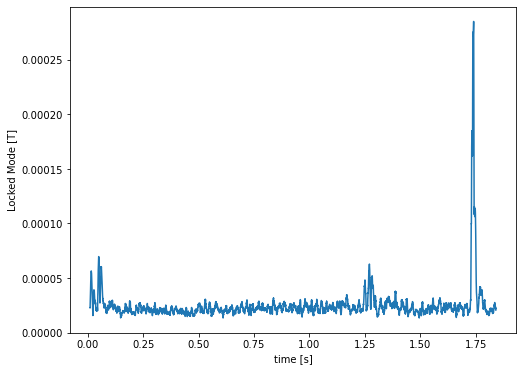

In [9]:
label_sources = data_shot["y"]["modes"]
fig, ax = plt.subplots()
fig.set_size_inches((8, 6))

time = label_sources["time"]
for i in range(5):
    ax.plot(time, label_sources[f"N{i}"], label=f"n={i}")
ax.set_ylim(0, 0.002)
ax.set_xlabel("time [s]")
ax.set_ylabel("Modes N [T]")
plt.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches((8, 6))

time = label_sources["time"]
ax.plot(time, label_sources[f"LM"], label=f"n={i}")
ax.set_xlabel("time [s]")
ax.set_ylabel("Locked Mode [T]")
plt.show()

An example method to get 'pseudo labels' (low quality automatically generated labels) is to take ranges of these signals above some threshold as a 'mode'. This could be used as the output of a data-driven method to predict start/end ranges from spectrograms (but do experiment with this yourself, e.g. defining labels yourself, other computer vision/image processing driven methods, different approaches to pseudo-labels):

In [10]:
def get_approx_timeranges(label_sources, mode_thresh=0.0005, nt_thresh=100, above_ratio=.9, min_t=.04):
    modes = np.sum(np.stack([label_sources[f"N{i}"] for i in range(5)]), axis=0)
    time = label_sources["time"]
    modes = gaussian_filter(modes, sigma=30)
    indices = list(np.where(modes > mode_thresh)[0])
    indices = [0] + indices + [len(label_sources["N0"])-1]
    nrange = []
    # find indices where there is a switch from above / below threshold, with 'nt_thresh' steps between
    indices_filter = [indices[i] for i in range(1, len(indices)-1) if (abs(indices[i-1] - indices[i]) > nt_thresh or abs(indices[i+1] -indices[i]) > nt_thresh)]
    # get corresponding start/end times
    tss, tes = [], []
    for i in range(0, len(indices_filter)):
        if i+1 >= len(indices_filter):
            break
        ia, ib = indices_filter[i], indices_filter[i+1]
        dinterval = modes[ia:ib]                                        
        if np.sum(dinterval > mode_thresh) < (ib - ia) * above_ratio:
            continue
        ts, te = time[ia], time[ib]
        if te - ts < min_t:
            continue
        tss.append(time[ia])
        tes.append(time[ib])
    return list(zip(tss, tes))

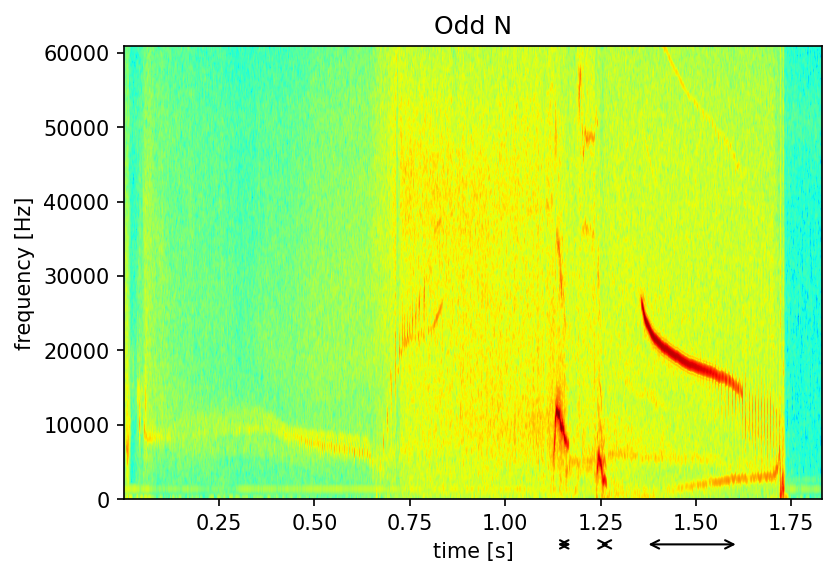

In [11]:
# get pseudo labels
mode_timings_auto = get_approx_timeranges(label_sources)

# plot the auto-generated ranges on the previously used spectrogram
fig, ax = plt.subplots()
ax.imshow(spec_odd_zoomed[::, ::-1].T, extent=(t[0], t[-1], f_zoomed[0], f_zoomed[-1]), aspect='auto', cmap='jet')

for ts, te in mode_timings_auto:
    ax.annotate('', xy=(ts / t[-1], -0.10), xycoords='axes fraction', xytext=(te / t[-1], -0.10), 
                        arrowprops=dict(arrowstyle="<->", color='black'))

ax.set_xlim(t[0], t[-1])
ax.set_ylim(f_zoomed[0], f_zoomed[-1])
ax.set_xlabel("time [s]")
ax.set_ylabel("frequency [Hz]")
fig.set_dpi(150)
plt.title("Odd N")
plt.show()